## Try and load validation datasets

In [15]:
## Inspect reactome stuff
import pandas as pd
import numpy as np
import os
import torch
#from cancernet.arch import PNet
#from cancernet.util import ProgressBar, InMemoryLogger, get_roc
from cancernet import PnetDataSet, ReactomeNetwork
#from cancernet.dataset import get_layer_maps
import cancernet.dataset.pnet_dataset as pnet_dataset
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
## Pnet dataset
## Initalise dataset
prostate_root = os.path.join("/home/cp3759/Projects/cancer-net-fresh/data/", "prostate")
dataset = PnetDataSet(
    root=prostate_root,
)

# loads the train/valid/test split from pnet
splits_root = os.path.join(prostate_root, "splits")
dataset.split_index_by_file(
    train_fp=os.path.join(splits_root, "training_set_0.csv"),
    valid_fp=os.path.join(splits_root, "validation_set.csv"),
    test_fp=os.path.join(splits_root, "test_set.csv"),
)

In [3]:
def tables_to_data_vector(valid_cnv,valid_mut,genes):
    """ Take in matrices of [tumor sample,genes] for both copy number variation
        and mutation"""
    cnv_amp=torch.empty((len(valid_cnv),len(genes)))
    cnv_del=torch.empty((len(valid_cnv),len(genes)))
    missing_count=0
    for aa,gene in enumerate(genes):
        if gene in valid_cnv:
            for bb in range(len(valid_cnv)):
                if valid_cnv[gene].values[bb]>1:
                    cnv_amp[bb][aa]=1
                    cnv_del[bb][aa]=0
                elif valid_cnv[gene].values[bb]<-1:
                    cnv_amp[bb][aa]=0
                    cnv_del[bb][aa]=1
                else:
                    cnv_amp[bb][aa]=0
                    cnv_del[bb][aa]=0
        else:
            missing_count+=1
            cnv_amp[:,aa]=torch.zeros(len(valid_cnv))
            cnv_del[:,aa]=torch.zeros(len(valid_cnv))
            
    print("%d training set genes missing from cnv set" % missing_count)

    mut_matrix=torch.empty((len(valid_mut),len(genes)))
    missing_count=0
    for aa,gene in enumerate(genes):
        if gene in valid_mut:
            ## Set to one-hot encoding, whether or not the gene is mutated
            for bb in range(len(valid_mut)):
                if valid_mut[gene].values[bb]>0:
                    mut_matrix[bb,aa]=1
                else:
                    mut_matrix[bb,aa]=0
            ## If the gene is not present, just set all entries to 0
        else:
            missing_count+=1
            mut_matrix[:,aa]=torch.zeros(len(valid_mut))
            
    print("%d training set genes missing from mut set" % missing_count)
    return torch.swapaxes(torch.stack((mut_matrix,cnv_amp,cnv_del)),0,1)

def load_process_Met(genes):
    valid_cnv = pd.read_csv("/scratch/cp3759/cancer-net/_database/prostate/external_validation/Met500/Met500_cnv.txt", index_col=0,sep='\t')
    valid_mut = pd.read_csv("/scratch/cp3759/cancer-net/_database/prostate/external_validation/Met500/Met500_mut_matrix.csv", index_col=0)
    valid_cnv=valid_cnv.T

    return tables_to_data_vector(valid_cnv,valid_mut,genes)

def load_process_PRAD(genes):
    valid_cnv = pd.read_csv("/scratch/cp3759/cancer-net/_database/prostate/external_validation/PRAD/cnv_matrix.csv", index_col=0)
    valid_mut = pd.read_csv("/scratch/cp3759/cancer-net/_database/prostate/external_validation/PRAD/mut_matrix.csv", index_col=0)
    
    return tables_to_data_vector(valid_cnv,valid_mut,genes)

In [4]:
data_vector_prad=load_process_PRAD(dataset.genes)

4 training set genes missing from cnv set
2647 training set genes missing from mut set


In [5]:
data_vector_met=load_process_Met(dataset.genes)

0 training set genes missing from cnv set
910 training set genes missing from mut set


#### Just train a normal model to apply to validation set for now

In [7]:
import os
import pickle
import pandas as pd
import numpy as np
import time
from tqdm import tqdm

from cancernet.arch import PNet
from cancernet import PnetDataSet, ReactomeNetwork
from cancernet.dataset import get_layer_maps
from cancernet.util import ProgressBar, InMemoryLogger, get_roc

import torch, torch_geometric.transforms as T, torch.nn.functional as F
from torch.utils.data.sampler import (
    SubsetRandomSampler,
    SequentialSampler,
    RandomSampler,
)
from torch_geometric.loader import DataLoader
import pytorch_lightning as pl
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
from sklearn.metrics import (
    roc_auc_score,
    roc_curve,
    auc,
    average_precision_score,
    f1_score,
    accuracy_score,
    precision_score,
    recall_score,
)

from typing import Iterable, Tuple


data_root="/home/cp3759/Projects/cancer-net-fresh/data"

## Load Reactome pathways
reactome_kws = dict(
    reactome_base_dir=os.path.join(data_root, "reactome"),
    relations_file_name="ReactomePathwaysRelation.txt",
    pathway_names_file_name="ReactomePathways.txt",
    pathway_genes_file_name="ReactomePathways.gmt",
)
reactome = ReactomeNetwork(reactome_kws)

## Initalise dataset
prostate_root = os.path.join(data_root, "prostate")
dataset = PnetDataSet(
    root=prostate_root,
)

# loads the train/valid/test split from pnet
splits_root = os.path.join(prostate_root, "splits")
dataset.split_index_by_file(
    train_fp=os.path.join(splits_root, "training_set_0.csv"),
    valid_fp=os.path.join(splits_root, "validation_set.csv"),
    test_fp=os.path.join(splits_root, "test_set.csv"),
)
pl.seed_everything(3478234589, workers=True)

n_epochs = 300
batch_size = 10
lr = 0.001
n_repeats=50
n_hidden=6

## Maps for pnet connections
maps = get_layer_maps(
    genes=dataset.genes,
    reactome=reactome,
    n_levels=n_hidden,
    direction="root_to_leaf",
    add_unk_genes=False,
    verbose=False,
)

train_loader = DataLoader(
    dataset,
    batch_size=batch_size,
    sampler=SubsetRandomSampler(dataset.train_idx),
    drop_last=True,
)
valid_loader = DataLoader(
    dataset,
    batch_size=batch_size,
    sampler=SubsetRandomSampler(dataset.valid_idx),
    drop_last=False,
)

test_loader = DataLoader(
    dataset,
    batch_size=batch_size,
    sampler=SubsetRandomSampler(
        dataset.test_idx,
        generator=torch.Generator().manual_seed(43),
    ),
    drop_last=False,
)

results = []

for _ in tqdm(range(1)):
    model = PNet(
        layers=maps,
        num_genes=maps[0].shape[0],  # 9229 now - including non HB genes
        class_weights=True,
        scheduler="pnet"
    )

    t0 = time.time()
    trainer = pl.Trainer(
        accelerator="auto",
        max_epochs=n_epochs,
        callbacks=None,
        logger=False,
        enable_checkpointing=False,
        enable_progress_bar=False
    )
    trainer.fit(model, train_loader, valid_loader)
    print(f"Training took {time.time() - t0:.1f} seconds.")

    fpr_test, tpr_test, test_auc, ys, outs = get_roc(
        model, test_loader, exp=False, seed=None
    )
    test_acc = accuracy_score(ys, outs[:, 1] > 0.5)
    test_aupr = average_precision_score(ys, outs[:, 1])
    test_f1 = f1_score(ys, outs[:, 1] > 0.5)
    test_precision = precision_score(ys, outs[:, 1] > 0.5)
    test_recall = recall_score(ys, outs[:, 1] > 0.5)
    
    result = {}
    result["auc"] = test_auc
    result["accuracy"] = test_acc
    result["aupr"] = test_aupr
    result["f1"] = test_f1
    result["precision"] = test_precision
    result["recall"] = test_recall
    
    for k, v in result.items():
        print(k, v)
    
    # result['pred'] = pd.DataFrame(np.vstack([np.array(y_hat).squeeze(), ys]).T, index=info_test_, columns=['pred_%i'%i for i in range(len(y_hat))] + ['y'])
    # need help fixing here to keep consistent with TF
    result["pred"] = outs
    result["y"] = ys

/ext3/miniconda3/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
INFO:lightning_fabric.utilities.seed:[rank: 0] Global seed set to 3478234589


pathways 1507
genes 9186
pathways 1397
genes 1515
pathways 1066
genes 1399
pathways 447
genes 1068
pathways 147
genes 448
pathways 26
genes 147
pathways 1
genes 26


  0%|          | 0/1 [00:00<?, ?it/s]INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.utilities.rank_zero:You are using a CUDA device ('NVIDIA A100-SXM4-80GB') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name              | Type       | Params
-------------------------------------------------
0 | netwo

Training took 386.0 seconds.


100%|██████████| 1/1 [06:28<00:00, 388.64s/it]

auc 0.9078719723183392
accuracy 0.8627450980392157
aupr 0.8684954979152416
f1 0.7741935483870968
precision 0.8571428571428571
recall 0.7058823529411765


In [8]:
data_vector_met=torch.swapaxes(data_vector_met,1,2)
data_vector_prad=torch.swapaxes(data_vector_prad,1,2)

In [9]:
model=model.eval()
with torch.no_grad():
    pred_met=model(data_vector_met)
    pred_prad=model(data_vector_prad)

(-0.05, 1.05)

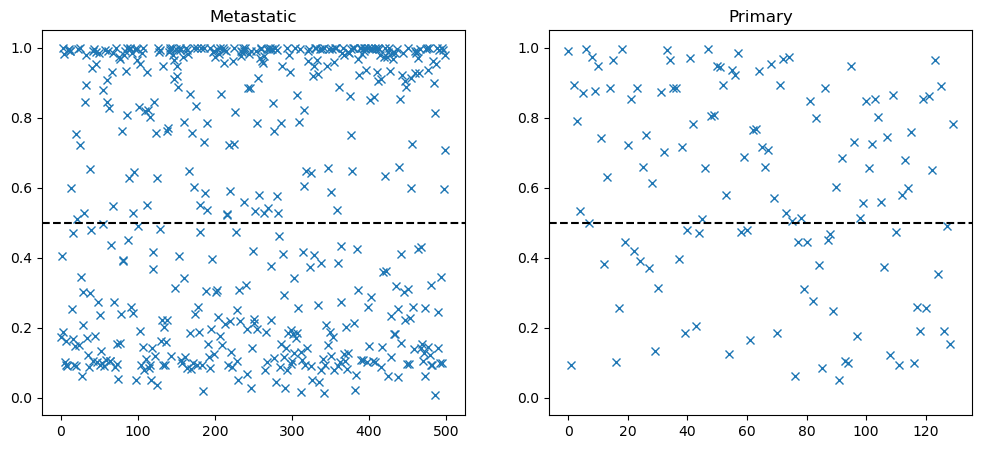

In [11]:
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.title("Metastatic")
plt.plot(pred_met[-1].flatten(),"x")
plt.axhline(0.5,color="black",linestyle="dashed")
plt.ylim(-0.05,1.05)
plt.subplot(1,2,2)
plt.title("Primary")
plt.plot(pred_prad[-1].flatten(),"x")
plt.axhline(0.5,color="black",linestyle="dashed")
plt.ylim(-0.05,1.05)

(-0.05, 1.05)

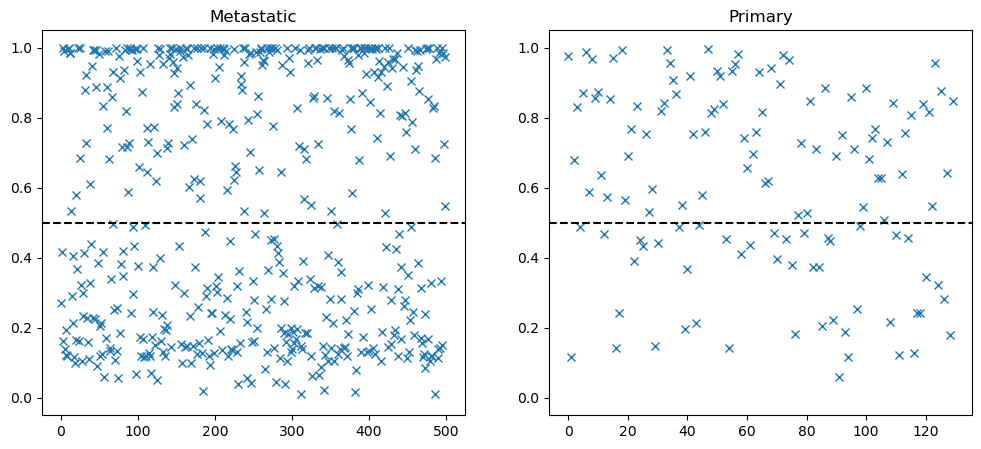

In [12]:
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.title("Metastatic")
plt.plot(np.mean(np.array([pred_met]).squeeze(),axis=0),"x")
plt.axhline(0.5,color="black",linestyle="dashed")
plt.ylim(-0.05,1.05)
plt.subplot(1,2,2)
plt.title("Primary")
plt.plot(np.mean(np.array([pred_prad]).squeeze(),axis=0),"x")
plt.axhline(0.5,color="black",linestyle="dashed")
plt.ylim(-0.05,1.05)

In [13]:
TP=(np.mean(np.array([pred_met]).squeeze(),axis=0)>0.5).sum()/len((np.mean(np.array([pred_met]).squeeze(),axis=0)))
FN=(np.mean(np.array([pred_met]).squeeze(),axis=0)<0.5).sum()/len((np.mean(np.array([pred_met]).squeeze(),axis=0)))
FP=(np.mean(np.array([pred_prad]).squeeze(),axis=0)>0.5).sum()/len((np.mean(np.array([pred_prad]).squeeze(),axis=0)))
TN=(np.mean(np.array([pred_prad]).squeeze(),axis=0)<0.5).sum()/len((np.mean(np.array([pred_prad]).squeeze(),axis=0)))

<Axes: >

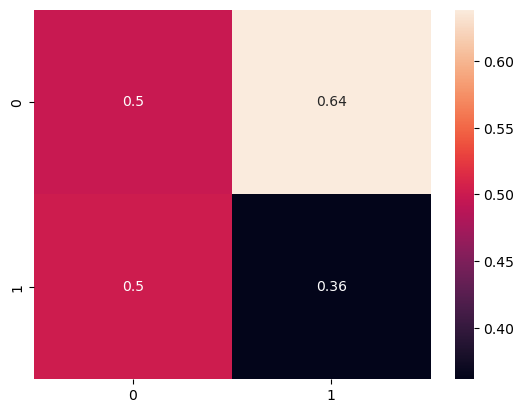

In [16]:
corr=np.array([[TP,FP],[FN,TN]])
sns.heatmap(corr,annot=True)

In [ ]:
def get_validation_primary(cols, cnv_split):
    current_dir = dirname(dirname(realpath(__file__)))
    validation_data_dir = join(current_dir, '_database/prostate/external_validation/')

    valid_cnv = pd.read_csv(join(validation_data_dir, 'PRAD/cnv_matrix.csv'), index_col=0)
    valid_mut = pd.read_csv(join(validation_data_dir, 'PRAD/mut_matrix.csv'), index_col=0)

    genes = cols.get_level_values(0).unique()
    genes_df = pd.DataFrame(index=genes)

    valid_mut_df = genes_df.merge(valid_mut.T, how='left', left_index=True, right_index=True).T
    valid_cnv_df = genes_df.merge(valid_cnv.T, how='left', left_index=True, right_index=True).T

    df_list = [valid_mut_df, valid_cnv_df]
    data_type_list = ['gene_final', 'cnv']

    if cnv_split:
        valid_cnv_ampl = valid_cnv_df.copy()
        valid_cnv_ampl[valid_cnv_ampl <= 0.0] = 0.
        valid_cnv_ampl[valid_cnv_ampl > 0.0] = 1.0

        valid_cnv_del = valid_cnv_df.copy()

        valid_cnv_del[valid_cnv_del >= 0.0] = 0.
        valid_cnv_del[valid_cnv_del < 0.0] = 1.0
        df_list = [valid_mut_df, valid_cnv_del, valid_cnv_ampl]
        data_type_list = ['mut', 'cnv_del', 'cnv_amp']

    all_data = pd.concat(df_list, keys=data_type_list, join='inner', axis=1, )
    all_data = all_data.swaplevel(i=0, j=1, axis=1)

    # order the columns based on genes
    order = all_data.columns.levels[0]
    all_data = all_data.reindex(columns=order, level=0)
    all_data.fillna(0, inplace=True)
    x = all_data.as_matrix()
    cols = all_data.columns
    rows = pd.DataFrame(index=all_data.index)
    y = np.zeros((x.shape[0],))
    return x, y, rows, cols

In [ ]:
x_train, y_train, info_train, cols_train = data.get_data()
x_test_mets, y_test_mets, info_test_mets, cols_test_mets = get_validation_metastatic(cols_train, cnv_split)
x_test_primary, y_test_primary, info_test_primary, cols_test_primary = get_validation_primary(cols_train,cnv_split)

In [ ]:
## Load Reactome pathways
reactome_kws = dict(
    reactome_base_dir=os.path.join("../data", "reactome"),
    relations_file_name="ReactomePathwaysRelation.txt",
    pathway_names_file_name="ReactomePathways.txt",
    pathway_genes_file_name="ReactomePathways.gmt",
)
reactome = ReactomeNetwork(reactome_kws)

In [ ]:
"/home/cp3759/Projects/cancer-net-fresh/data/reactome"